In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
gpus=tf.config.list_physical_devices('gpus')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()
images=np.concatenate([x_train,x_test])
labels=np.concatenate([y_train,y_test])
images=np.expand_dims(images,axis=-1)
labels=np.expand_dims(labels,axis=-1)
images=((images-127.5)/127.5).astype(np.float32)
print(images.shape,labels.shape)

11501568/11490434 [==============================] - 0s 0us/step
(70000, 28, 28, 1) (70000, 1)


In [4]:
num_classes=10
num_channels=1
latent_dim=128
batch_size=400

In [5]:
from matplotlib import pyplot as plt

In [6]:
def show_images(images):
    if len(images.shape)==4:
        images=np.squeeze(images)
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for idx in range(images.shape[0]):
        plt.subplot(4,8,idx+1)
        plt.imshow(images[idx],cmap='Purples')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_generated_images():
    noise=tf.random.normal((32,latent_dim,1))
    fake_images=wgan_generator(noise,training=False)
    show_images(fake_images)

In [7]:
data=tf.data.Dataset.from_tensor_slices(images)
data=data.cache()
data=data.shuffle(images.shape[0])
data=data.batch(batch_size)
data=data.prefetch(batch_size//2)

In [8]:
data_iterator=data.as_numpy_iterator()

In [9]:
sample_images=data_iterator.next()
sample_images.shape,sample_images.max(),sample_images.min()

((400, 28, 28, 1), 1.0, -1.0)

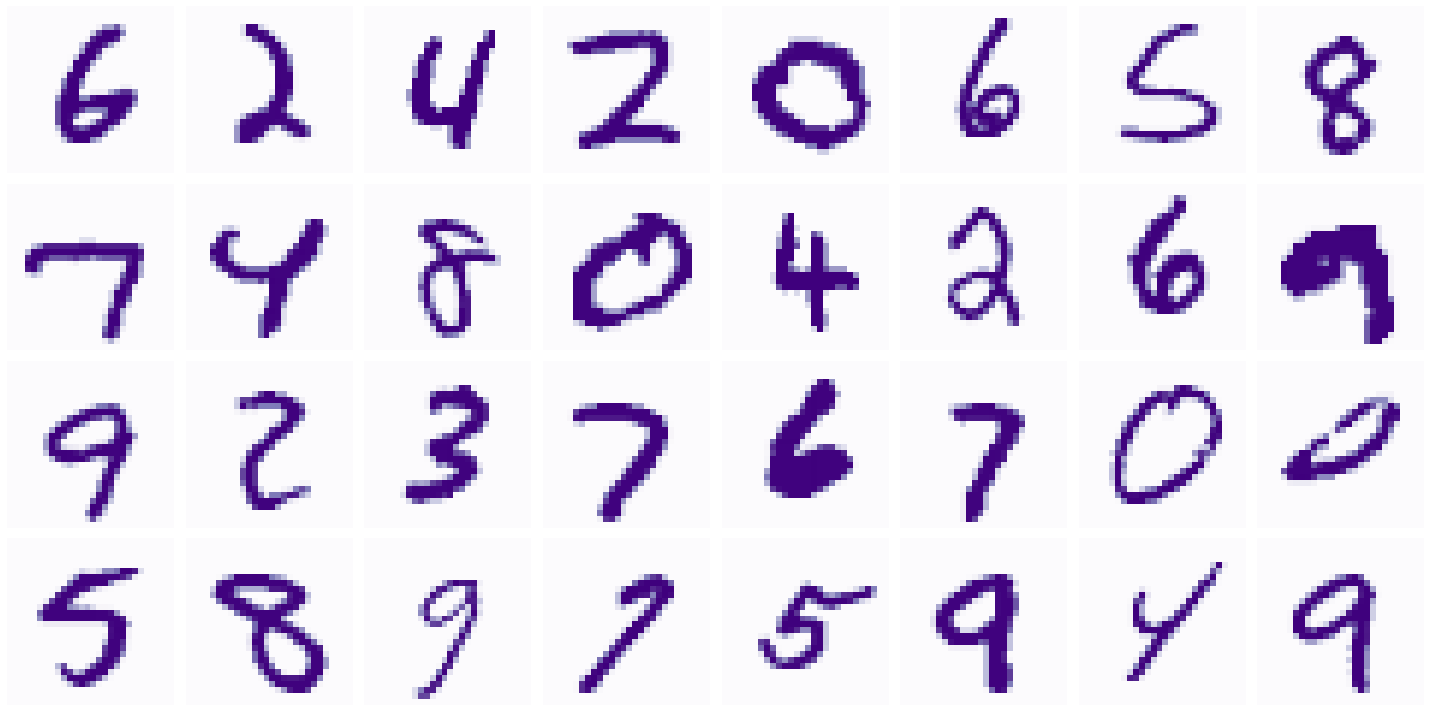

In [10]:
sample_images=data_iterator.next()[:32]
show_images(sample_images)

In [11]:
from tensorflow.keras import Sequential,layers,initializers
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Flatten,Dropout,BatchNormalization,Dense,Reshape,LeakyReLU

In [50]:
def build_generator(latent_dim=latent_dim):
    model=Sequential(name='wgan_generator')

    model.add(Dense(7*7*128,use_bias=False,input_shape=(latent_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(.2))
    model.add(Reshape((7,7,128)))

    model.add(Conv2DTranspose(64,(4,4),strides=(2,2),padding='same',use_bias=False,kernel_initializer=initializers.RandomNormal()))
    model.add(BatchNormalization())
    model.add(LeakyReLU(.2))

    model.add(Conv2DTranspose(1,(4,4),strides=(2,2),padding='same',use_bias=False,kernel_initializer=initializers.RandomNormal()))
    model.add(tf.keras.layers.Activation('tanh'))

    return model

In [51]:
wgan_generator=build_generator()
wgan_generator.summary()

Model: "wgan_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              802816    
                                                                 
 batch_normalization_2 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       131072    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)    

In [16]:
from tensorflow.keras.utils import plot_model

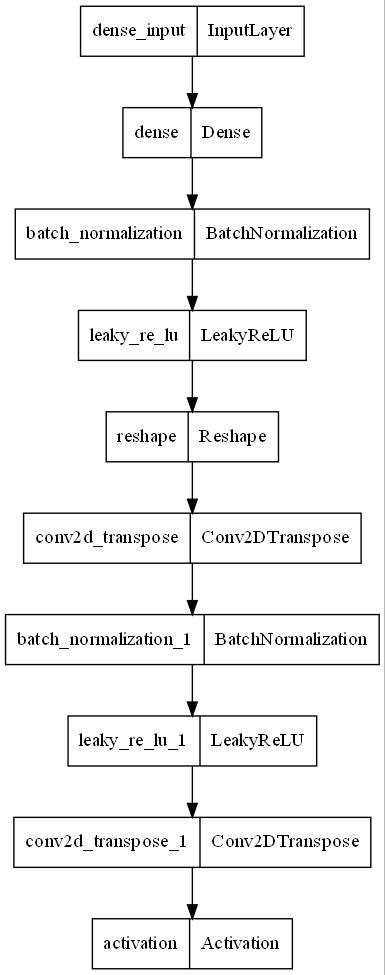

In [17]:
plot_model(wgan_generator,to_file='generator_architecture.jpg',dpi=100)

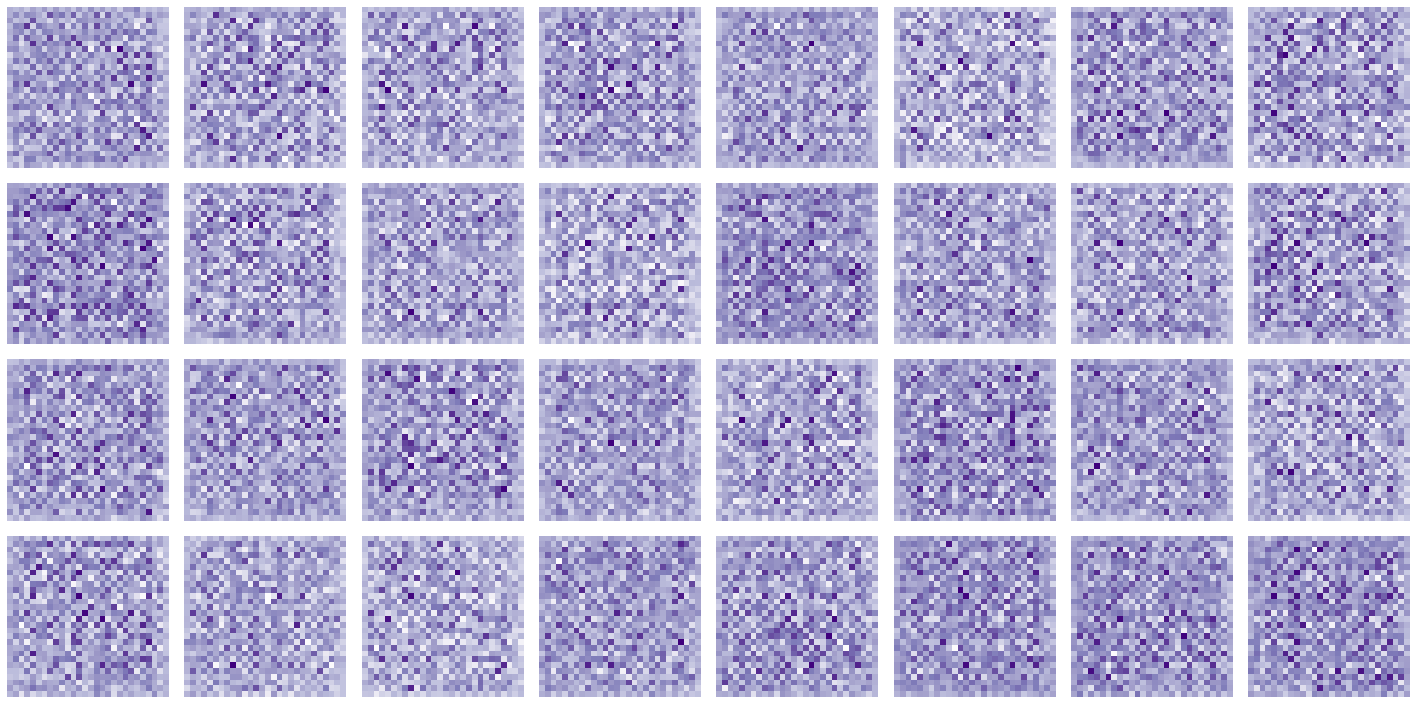

In [59]:
noise=np.random.normal(size=(32,latent_dim,1))
fake_images=wgan_generator(noise,training=False)
show_images(fake_images)

In [14]:
def build_critic(input_shape=(28,28,1)):
    model=Sequential(name='wgan_critic')

    model.add(Conv2D(128,(4,4),strides=(2,2),padding='same',input_shape=input_shape))
    model.add(LeakyReLU(.2))

    model.add(Conv2D(256,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(.2))

    model.add(Conv2D(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(.2))

    model.add(Flatten())
    model.add(Dropout(.1))
    model.add(Dense(1))
    return model

In [15]:
wgan_critic=build_critic()
wgan_critic.summary()

Model: "wgan_critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       2176      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         524544    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         524416    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              

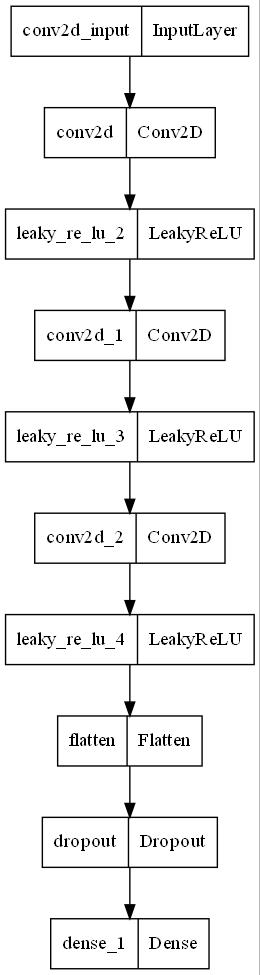

In [18]:
plot_model(wgan_critic,to_file='critic_architecture.jpg',dpi=100)

In [18]:
noise=np.random.normal(size=(2,latent_dim,1))
fake_images=wgan_generator(noise,training=False)
real_images=data_iterator.next()[:2]
wgan_critic(fake_images,training=False),wgan_critic(real_images,training=False)

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 0.00158279],
        [-0.0003421 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.09035414],
        [0.0862609 ]], dtype=float32)>)

In [19]:
from tensorflow.keras import Model

In [20]:
class WassersteinGAN(Model):
    def __init__(self,generator,critic,latent_dim,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.wgan_generator=generator
        self.wgan_critic=critic
        self.latent_dim=latent_dim
    
    def compile(self,c_opt,g_opt):
        super().compile()
        self.wgan_critic_optimizer=c_opt
        self.wgan_generator_optimizer=g_opt
    
    def train_step(self,batch):
        real_images=batch
        epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
        
        for i in range(3):
            with tf.GradientTape() as c_tape:
                with tf.GradientTape() as gp_tape:
                  fake_images=self.wgan_generator(tf.random.normal((batch_size,self.latent_dim,1)),training=False)
                  fake_image_mixed = epsilon * tf.dtypes.cast(real_images, tf.float32) + ((1 - epsilon) * fake_images)
                  fake_mixed_pred = self.wgan_critic([fake_image_mixed], training=True)
                  
                grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
                grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
                gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
                
                fake_preds = self.wgan_critic([fake_images], training=True)
                real_preds = self.wgan_critic([real_images], training=True)
                
                c_loss = tf.reduce_mean(fake_preds) - tf.reduce_mean(real_preds) + 10 * gradient_penalty

            c_grad=c_tape.gradient(c_loss,self.wgan_critic.trainable_variables)
            self.wgan_critic_optimizer.apply_gradients(zip(c_grad,self.wgan_critic.trainable_variables))

        with tf.GradientTape() as g_tape:
            fake_images=self.wgan_generator(tf.random.normal((batch_size,self.latent_dim,1)),training=True)
            predicted_scores=self.wgan_critic(fake_images,training=False)
            g_loss=-tf.reduce_mean(predicted_scores)
        
        g_grad=g_tape.gradient(g_loss,self.wgan_generator.trainable_variables)
        self.wgan_generator_optimizer.apply_gradients(zip(g_grad,self.wgan_generator.trainable_variables))

        return {'c_loss':c_loss,'g_loss':g_loss}

In [21]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.optimizers import Adam

In [22]:
generator_optimizer=Adam(learning_rate=0.00002,beta_1=.5,beta_2=.9)
critic_optimizer=Adam(learning_rate=0.00001,beta_1=.5,beta_2=.9)

In [25]:
class WGANMonitor(Callback):
    def __init__(self,num_images,latent_dim=128):
        self.num_images=num_images
        self.latent_dim=latent_dim
    
    def on_epoch_end(self,epoch,logs=None):
        if (epoch+1)%2:
            fake_images=wgan_generator(tf.random.normal((self.num_images,self.latent_dim,1)),training=False)
            fake_images=((fake_images*127.5)+127.5)
            fake_images=tf.cast(fake_images,dtype=tf.int32)
            for i in range(self.num_images):
                img=array_to_img(fake_images[i])
                img.save(os.path.join('generated',f'fake-img-{epoch+1}-{i+1}.jpg'))

In [23]:
wgan_generator=tf.keras.models.load_model(os.path.join('models','wgan_generator.h5'))
wgan_critic=tf.keras.models.load_model(os.path.join('models','wgan_critic.h5'))

In [26]:
wgan=WassersteinGAN(wgan_generator,wgan_critic,latent_dim)
wgan_monitor=WGANMonitor(1)

In [27]:
wgan.compile(critic_optimizer,generator_optimizer)

In [28]:
import time

In [38]:
tstart=time.time()
history=wgan.fit(
    data,
    epochs=120,
    callbacks=[
        wgan_monitor,tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(os.path.join('temp','checkpoint'),save_weights_only=True,monitor='c_loss',save_best_only=True)
    ]
)
tend=time.time()

Epoch 1/45
175/175 [==============================] - 121s 658ms/step - c_loss: -1.7752 - g_loss: -6.2819
Epoch 2/45
175/175 [==============================] - 116s 661ms/step - c_loss: -1.7775 - g_loss: -6.2507
Epoch 3/45
175/175 [==============================] - 116s 663ms/step - c_loss: -1.7725 - g_loss: -6.2171
Epoch 4/45
175/175 [==============================] - 116s 662ms/step - c_loss: -1.7613 - g_loss: -6.1415
Epoch 5/45
175/175 [==============================] - 116s 660ms/step - c_loss: -1.7556 - g_loss: -6.1652
Epoch 6/45
175/175 [==============================] - 116s 661ms/step - c_loss: -1.7435 - g_loss: -6.1872
Epoch 7/45
175/175 [==============================] - 116s 661ms/step - c_loss: -1.7570 - g_loss: -6.0991
Epoch 8/45
175/175 [==============================] - 116s 663ms/step - c_loss: -1.7664 - g_loss: -6.1097
Epoch 9/45
175/175 [==============================] - 116s 662ms/step - c_loss: -1.7504 - g_loss: -6.0784
Epoch 10/45
175/175 [=========================

In [32]:
hours=int(tend-tstart)//3600
mins=int(tend-tstart-hours*3600)//60
seconds=int(tend-tstart-hours*3600-mins*60)
print(f'Training Time: {hours}:{mins}:{seconds}')

Training Time: 4:21:43


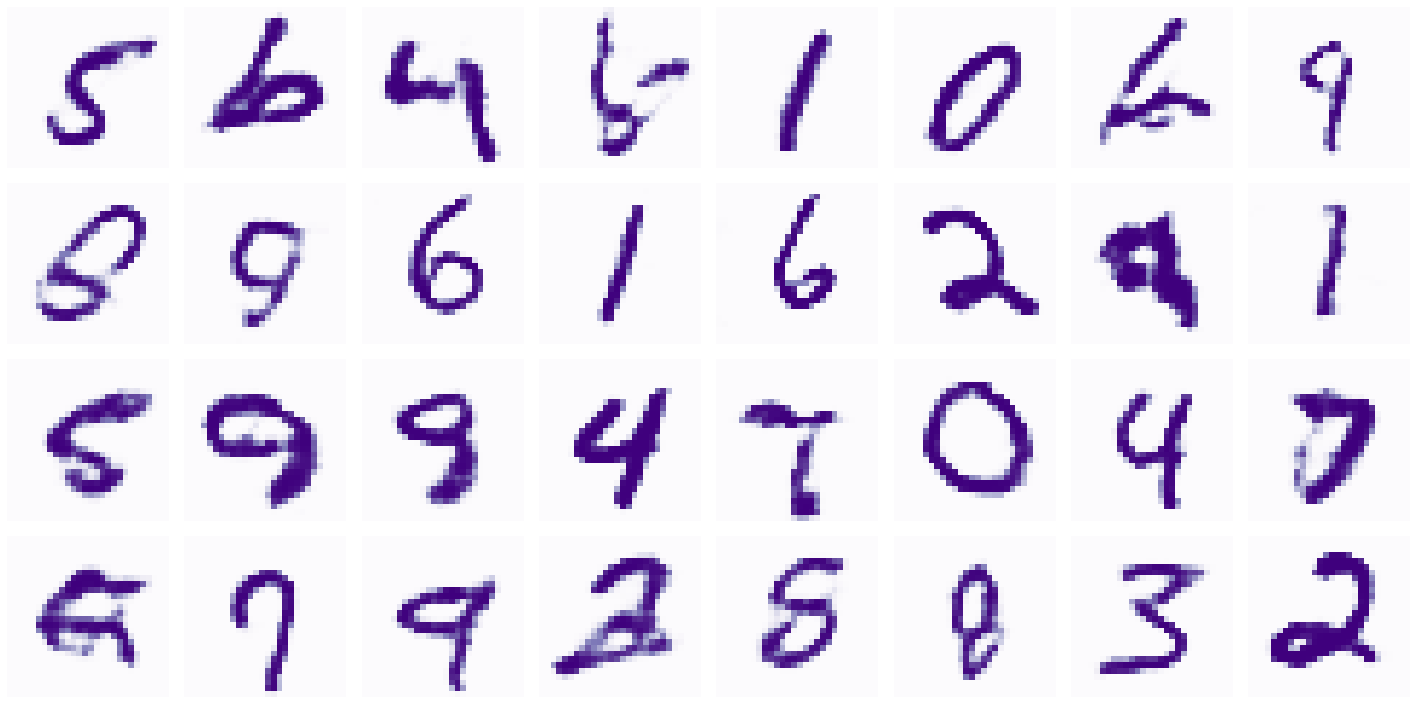

In [49]:
show_generated_images()

In [30]:
import pandas as pd

In [42]:
# ---------- CAUTION -------------

# df=pd.DataFrame(history.history)
# df.to_csv('loss_trend.csv',index=False)

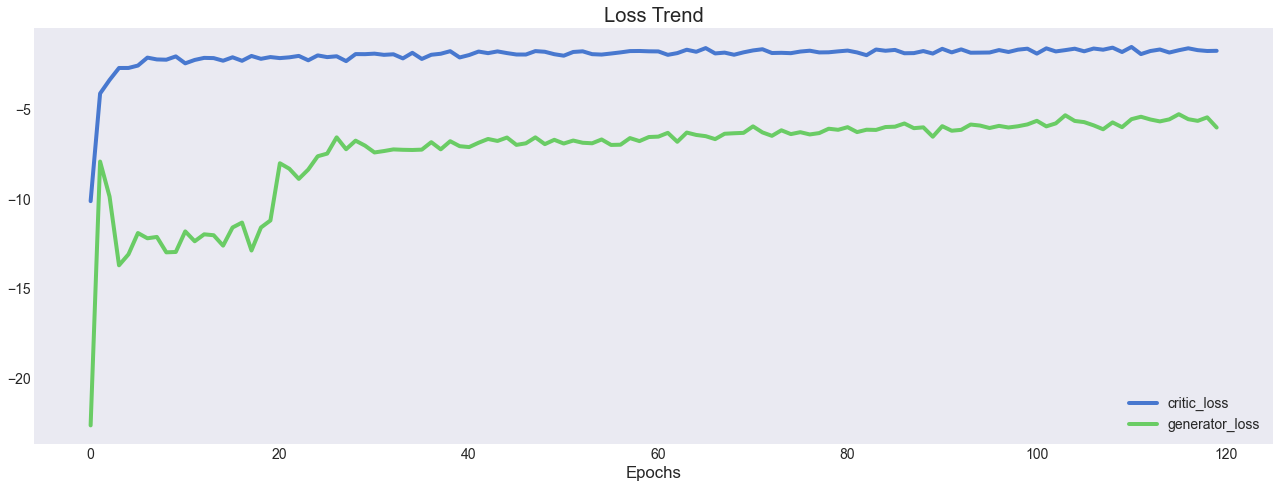

In [38]:
df=pd.read_csv('loss_trend.csv')
plt.style.use('seaborn-muted')
plt.figure(figsize=(18,7))
plt.plot(df['c_loss'],label='critic_loss')
plt.plot(df['g_loss'],label='generator_loss')
plt.xlabel('Epochs')
plt.title('Loss Trend')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
# ------------!!!  CAUTION  !!!---------------------

# if not os.path.exists('metadata'):
#     os.mkdir('metadata')
# wgan_generator.save('metadata')
# wgan_critic.save('metadata')
# if not os.path.exists('models'):
#     os.mkdir('models')
# tf.keras.models.save_model(wgan_generator,os.path.join('models','wgan_generator.h5'))
# tf.keras.models.save_model(wgan_critic,os.path.join('models','wgan_critic.h5'))